In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf
from osgeo import gdal
from rasterstats import zonal_stats
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# Task 2.4: Calculate residence times

## Part A: Estimate lake volumes

From the proposal text:

> **Oppgave 2.4: Beregne oppholdstider**
>
> NVEs innsjødybdedatabase skal brukes til å utvikle en statistisk modell som kan forutsi innsjøvolum (og dermed oppholdstid). Standardtilnærmingen vil bruke en regresjon av gjennomsnittlig vanndybde mot innsjøarealet (som i den opprinnelige TEOTIL modellen). Ytterligere kovariater, slik som gjennomsnittlig helning og høyde, vil også bli utforsket for å lage en mer robust statistisk modell, hvis mulig. Tilpasset regresjon vil bli brukt til å estimere innsjøvolum og oppholdstid for innsjøer langs hovedelver i hvert reginefelt. En Jupyter-notisbok som dokumenterer den statistiske utforskningen vil bli lagt til TEOTILs dokumentasjon.

**Note:** This notebook performs raster processing with a Norway-wide DEM. If `dem_res = 40`, it should run OK on a `standard` machine; otherwise, login using one of the `high memory` machines to avoid RAM issues.

## 1. Read NVE's lake datasets

In [2]:
data_year = 2022

data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{data_year}"
nve_gdb = os.path.join(data_fold, "hydrology", "NVEData.gdb")

### 1.1. Depth data

In [3]:
# Depth data
dep_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="InnsjoDybdedata").to_crs(
    "epsg:25833"
)

# Pretty sure 'omkrets_m' in the NVE data should actually be 'omkrets_km'
cols = [
    "vatnLnr",
    "innsjoAreal_km2",
    "omkrets_m",
    "middelDyp_m",
    "maksDyp_m",
    "volum_Mm3",
    "oppholdstid_Aar",
    "vassdragsnummer",
    "geometry",
]
new_cols = [
    "vatnLnr",
    "nve_area_km2",
    "nve_perim_km",
    "avg_dep_m",
    "max_dep_m",
    "vol_Mm3",
    "res_time_yr",
    "regine",
    "geometry",
]
dep_gdf = dep_gdf[cols]
dep_gdf.columns = new_cols
dep_gdf.head()

,vatnLnr,nve_area_km2,nve_perim_km,avg_dep_m,max_dep_m,vol_Mm3,res_time_yr,regine,geometry
0,2,51.00,0.00,190.0,460.0,9700.000,2.897308,016.G11,"MULTIPOLYGON (((152786.800 6666648.948, 152805..."
1,3,78.51,206.62,20.0,68.5,1573.523,1.000000,016.J11,"MULTIPOLYGON (((104358.251 6675071.184, 104375..."
2,6,58.40,0.00,87.0,171.0,5100.000,0.609125,016.B3,"MULTIPOLYGON (((174009.800 6597685.339, 174017..."
3,7,18.70,0.00,67.0,152.0,1260.000,0.390202,016.BB11,"MULTIPOLYGON (((141357.040 6591615.078, 141351..."
4,8,13.80,0.00,92.0,201.0,1280.000,0.412603,016.BB11,"MULTIPOLYGON (((139013.050 6593849.708, 139016..."


### 1.2. Lakes database

In [4]:
# All lakes
lake_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="Innsjo").to_crs("epsg:25833")
cols = [
    "vatnLnr",
    "navn",
    "vassdragsnummer",
    "vassdragsomradeNr",
    "hoyde_moh",
    "arealInnsjo_km2",
    "arealNedborfelt_km2",
    "dybdekart",
    "geometry",
]
new_cols = [
    "vatnLnr",
    "name",
    "regine",
    "vassom",
    "elev_m",
    "area_km2",
    "catch_area_km2",
    "vol_est_avail",
    "geometry",
]
lake_gdf = lake_gdf[cols]
lake_gdf.columns = new_cols
lake_gdf["vol_est_avail"].replace({None: 0, "J": 1}, inplace=True)
lake_gdf.head()

,vatnLnr,name,regine,vassom,elev_m,area_km2,catch_area_km2,vol_est_avail,geometry
0,505,Aahkanjaevrie,155.D1B,155,718.0,3.4267,16.06,0,"MULTIPOLYGON (((446342.960 7294575.240, 446352..."
1,36452,Svartvatnet,116.B,116,419.0,0.0494,0.37,0,"MULTIPOLYGON (((191800.740 7031154.190, 191874..."
2,81309,Gåntjern,002.ACB,002,207.0,0.0397,0.36,0,"MULTIPOLYGON (((301121.050 6596125.670, 301117..."
3,101659,None,119.62B,119,NaN,0.0059,0.08,0,"MULTIPOLYGON (((229911.430 7049804.700, 229920..."
4,143542,None,116.B,116,NaN,0.0058,0.05,0,"MULTIPOLYGON (((192887.790 7031240.180, 192883..."


## 2. Data cleaning, filtering and checking

The raw NVE depth dataset contains some strange values e.g. the `avg_dep_m` and `vol_Mm3` columns include zero and negative values, which don't make sense. There is also one very large outlier (`vatnLnr = 3180`) with an area of 0.32 km2 and a volume of 1435361 Mm3. This must be an error - perhaps it should be 1.435361 Mm3? I'll remove these for now.

Furthermore, some of the areas in the lake depth attribute table do not match the polygon areas from GIS. In some cases, areas given in the depth dataset are also significantly different from those in NVE's main lakes database. As a check of the depth dataset, I will recalculate these values for all lakes.

NVE's lakes database also has some odd values: some lakes do not have regine codes or vassdragsomrader, and others have either zero or negative values for `area_km2` or `catch_area_km2`. These issues affect a small number of lakes, which I have removed from the dataset. There are also around 70 duplicated lakes in the main NVE database (i.e. same `vatnLnr`, but different properties). I am not sure how to interpret this, but something seems to be wrong here, so I will remove these too.

**The original TEOTIL model only considered lakes larger than 0.025 km2** (see [here](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/214825/5914-2010_200dpi.pdf?sequence=2&isAllowed=y)). For consistency I will do the same here, although this could be changed later, if desired.

Finally, Mjøsa (`vatnLnr = 118`) is much larger than any of the other lakes in the main database (it has a surface area of 369 km2, compared to 218 km2 for the next largest waterbody). Since most of the large lakes in the database already have volume estimates based on bathymetric data, I do not need to estimate volumes for very large lakes. The largest lake without an existing volume estimate is 134 km2, and there are only three lakes >50 km2 without existing volume estimates. **I will therefore remove Mjøsa from the final dataset used for statistical analysis** (see later in this notebook), as it is a large outlier and probably not relevant for estimating volumes in smaller lakes.

In [5]:
# Remove weird values in depth dataset
dep_gdf = dep_gdf.query(
    "(vol_Mm3 > 0) and (avg_dep_m > 0) and (vatnLnr != 3180)"
).dropna(subset=["nve_area_km2", "avg_dep_m", "vol_Mm3"])

# Remove weird values in lakes database
lake_gdf.dropna(subset=["vatnLnr", "regine", "vassom"], inplace=True)
lake_gdf = lake_gdf.query("(area_km2 > 0) and (catch_area_km2 > 0)")
lake_gdf.drop_duplicates(subset="vatnLnr", keep=False, inplace=True)

# Size threshold used in the original model
lake_gdf = lake_gdf.query("area_km2 > 0.025")

print(f"There are {len(lake_gdf)} valid lakes in the lakes database.")
print(f"Of these, {len(dep_gdf)} have valid average depth and volume measurements.")

There are 54722 valid lakes in the lakes database.
Of these, 393 have valid average depth and volume measurements.


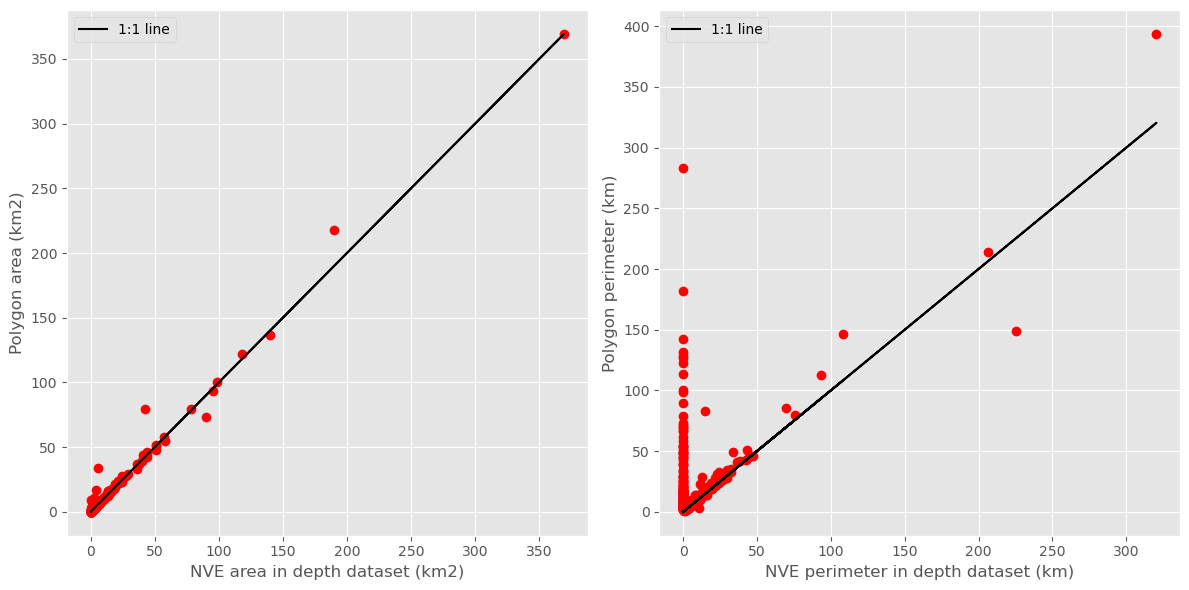

In [6]:
# Check area and perimeter measurements in depth data
dep_gdf["area_km2"] = dep_gdf["geometry"].area / 1e6
dep_gdf["perim_km"] = dep_gdf["geometry"].length / 1e3

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].plot(dep_gdf["nve_area_km2"], dep_gdf["area_km2"], "ro")
axes[0].plot(dep_gdf["nve_area_km2"], dep_gdf["nve_area_km2"], "k-", label="1:1 line")
axes[0].set_xlabel("NVE area in depth dataset (km2)")
axes[0].set_ylabel("Polygon area (km2)")
axes[0].legend(loc="upper left")

axes[1].plot(dep_gdf["nve_perim_km"], dep_gdf["perim_km"], "ro")
axes[1].plot(dep_gdf["nve_perim_km"], dep_gdf["nve_perim_km"], "k-", label="1:1 line")
axes[1].set_xlabel("NVE perimeter in depth dataset (km)")
axes[1].set_ylabel("Polygon perimeter (km)")
axes[1].legend(loc="upper left")

plt.tight_layout()

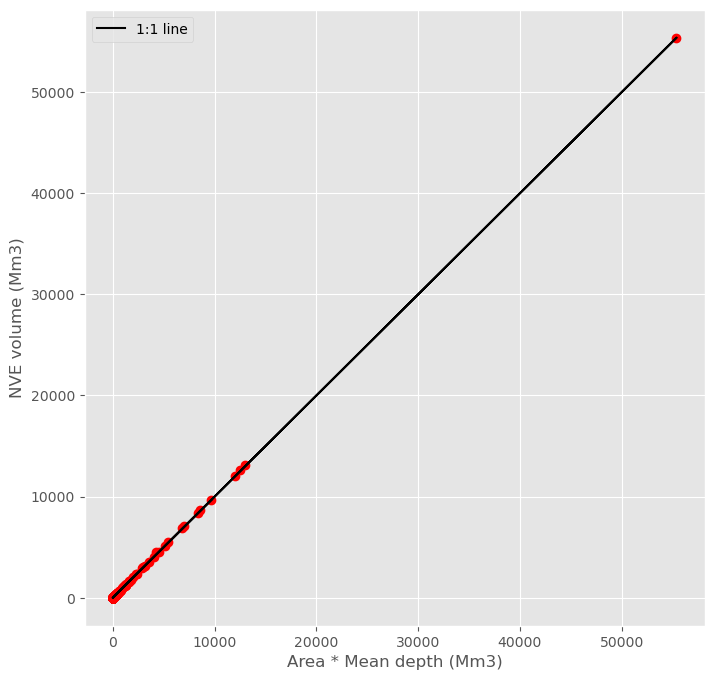

In [7]:
# Confirm that NVE's volume estimates are consistent with nve_area * avg_depth
dep_gdf["vol2_Mm3"] = dep_gdf["nve_area_km2"] * dep_gdf["avg_dep_m"]
dep_gdf["vol_ratio"] = dep_gdf["vol_Mm3"] / dep_gdf["vol2_Mm3"]

poss_nve_errors = dep_gdf.query("vol_ratio > 2")
if len(poss_nve_errors) > 0:
    print(
        "NVE's volume estimates for some lakes do not match their reported area and mean depth values."
    )
    display(poss_nve_errors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(dep_gdf["vol2_Mm3"], dep_gdf["vol_Mm3"], "ro")
ax.plot(dep_gdf["vol2_Mm3"], dep_gdf["vol2_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("Area * Mean depth (Mm3)")
ax.set_ylabel("NVE volume (Mm3)")
ax.legend(loc="upper left")

del dep_gdf["vol2_Mm3"], dep_gdf["vol_ratio"]

Based on the plots above, it seems clear that NVE's volume estimates have been calculated `area * mean_depth`, but that lake areas used in the depth dataset sometimes differ significantly from the lake polygons in NVE's database. I assume this is because lots of the depth surveys are underpinned by old topographic data. For consistency, I will use the areas and volumes reported in the depth dataset to derive statistical relationships, and then use the actual polygon areas from the lakes database for prediction.

## 3. Parameters/covariates of interest

In addition to the raw data in the NVE database, there are many additional parameters/characteristics that could be useful for predicting lake volume. In order for statistical tests to be fair, it is important that all models and methods are evaluated using the same data. In this section, I will therefore derive all parameters (i.e. possible covariates) used by the models under consideration to create a single dataset that can be used for model comparison and evaluation.

### 3.1. Lake shape

Are long, narrow lakes typically deeper than broad ones? For constant slope, broad lakes should be deeper; on the other hand, in boreal landscapes strongly influenced by glacial processes, long, narrow lakes may be deeper than broad ones, because they occupy deeply incised former river valleys or glacial troughs. Either way, I hypothesise that the **aspect ratio** of a lake may be a useful predictor of mean depth.

Aspect ratio is defined as the ratio of length to width. For arbitrary shapes such as lakes, length is typically defined as the longest straight line measured shoreline-to-shoreline across the surface, and width is taken to be the longest shoreline-to-shoreline distance perpendicular to the length (see e.g. [here](https://www.lakescientist.com/lake-shape/)). However, algorithms for calculating these quantities for generic polygons are fiddly and computationally intensive.

An alternative definition for width and length can be obtained by modelling each lake as a rectangle with the same perimeter and area as the original lake polygon. Consider a rectangle of length $l$ and width $w$. The perimeter is $P = 2l + 2w$ and the area is $A = lw$. By substituting for $l$ we obtain the quadratic

$$P = \frac{2A}{w} + 2w$$

or 

$$2w^2 - Pw + 2A = 0$$

This can be solved using the quadratic formula to give

$$w = \frac{P - \sqrt{P^2 - 16A}}{4}$$

and 

$$l = \frac{P + \sqrt{P^2 - 16A}}{4}$$

For arbitrary elongated shapes, these equations can be used as reasonable *definitions* for length and width, from which aspect ratio can be calculated.

**Note:** For a square, $P^2 = 16A$, so $l = w = \frac{P}{4}$, which is correct. However, this approach will give complex output for any shape where $16A > P^2$ (e.g. circles). In such cases, it is probably sensible to model circles as squares with either the same area or the same perimeter as the original circle (i.e `aspect_ratio = 1`).

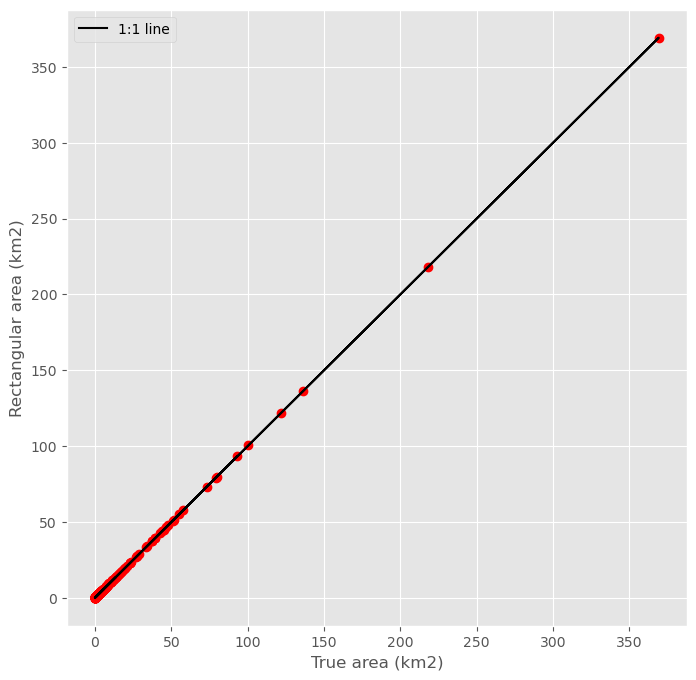

In [8]:
# Calculate 'width' and 'length' from perim and area
# Use polygon shapes rather than NVE data
dep_gdf["width_km"] = (
    dep_gdf["perim_km"] - (dep_gdf["perim_km"] ** 2 - 16 * dep_gdf["area_km2"]) ** 0.5
) / 4
dep_gdf["length_km"] = (
    dep_gdf["perim_km"] + (dep_gdf["perim_km"] ** 2 - 16 * dep_gdf["area_km2"]) ** 0.5
) / 4

dep_gdf["aspect_ratio"] = dep_gdf["length_km"] / dep_gdf["width_km"]

# Handle complex results
dep_gdf["aspect_ratio"].fillna(1, inplace=True)
dep_gdf["width_km"].fillna(dep_gdf["area_km2"]**0.5, inplace=True)

assert np.iscomplex(dep_gdf["width_km"]).sum() == 0
assert np.iscomplex(dep_gdf["length_km"]).sum() == 0

# Check w * l = A
dep_gdf["area2_km2"] = dep_gdf["width_km"] * dep_gdf["length_km"]
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(dep_gdf["area2_km2"], dep_gdf["area_km2"], "ro")
ax.plot(dep_gdf["area2_km2"], dep_gdf["area2_km2"], "k-", label="1:1 line")
ax.set_xlabel("True area (km2)")
ax.set_ylabel("Rectangular area (km2)")
ax.legend(loc="upper left")
del dep_gdf["area2_km2"]

dep_gdf.dropna(subset="aspect_ratio", inplace=True)

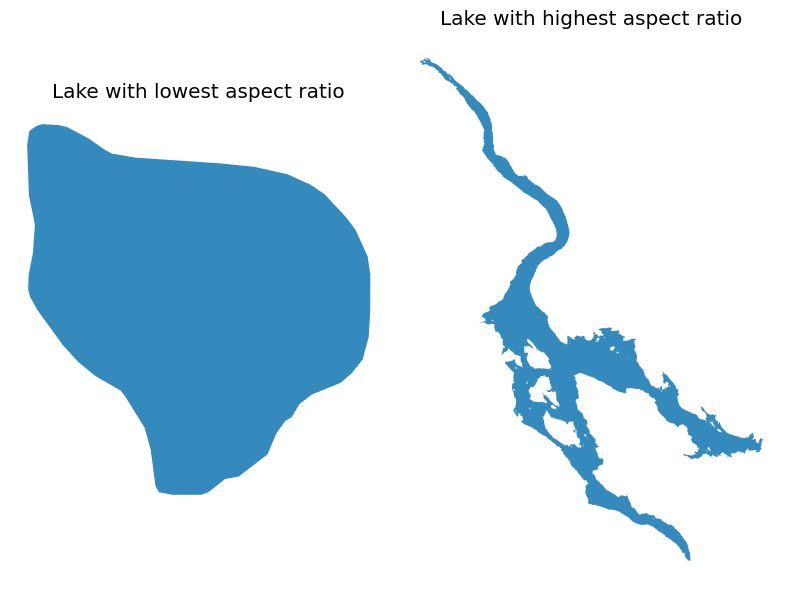

In [9]:
# Plot lakes with low and high aspect ratios
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
dep_gdf.sort_values("aspect_ratio").iloc[[0]].plot(ax=axes[0])
dep_gdf.sort_values("aspect_ratio").iloc[[-1]].plot(ax=axes[1])
axes[0].set_title("Lake with lowest aspect ratio")
axes[1].set_title("Lake with highest aspect ratio")
axes[0].axis("off")
axes[1].axis("off")
plt.tight_layout()

### 3.2. Terrain characteristics

Landscape characteristics in the vicinity of a lake may give clues about the bathymetry. An obvious way to approach this is to **buffer** the lake polygons by some width, $b$, and then use zonal statistics to calculate terrain properties (e.g. slope and elevation characteristics) within a strip of width $b$ around each lake's margin. The code below calculates min, mean, max, std. dev., median and percentiles for both elevation (in metres) and slope (in degrees) in the region around the edge of each lake. Furthermore, following [Heathcoate et al. (2015)](https://cdnsciencepub.com/doi/10.1139/cjfas-2014-0392), I have calculated the **mean elevation change** in the buffered zone (estimated as $mean\_elevation - min\_elevation$). The justification for this is that the mean topography in the area around a lake may be a good predictor of the mean topography below the surface.

For the buffering, some authors (e.g. [Heathcoate et al., 2015](https://cdnsciencepub.com/doi/10.1139/cjfas-2014-0392)) used a buffer distance proportional to the lake size (rather than a fixed value, as used by e.g. [Sobek et al., 2011](https://www.diva-portal.org/smash/get/diva2:574714/FULLTEXT02.pdf)), under the assumption that the bathymetry of larger lakes is probably best represented by a similarly large part of the surrounding landscape. This seems reasonable, but Heathcoate et al. suggested the buffer distance should be 25% of the equivalent diameter, $D$, of the lake, where $D = 2 \sqrt{\frac{A}{\pi}}$ and $A$ is the lake's surface area. This seems pretty arbitrary, so in the code below I've used 0.5 times my lake width estimate instead (i.e. the combined buffer width over both shores is equal to the width of the lake), because I think it has a better physical basis.

In [10]:
dtm_res = 10

In [11]:
buffer = (
    0.5 * 1000 * dep_gdf["width_km"]
)  # fixed value in metres or pandas Series with lake-specific buffer distances
temp_fold = r"/home/jovyan/shared/01_datasets/spatial/temp"

In [12]:
# Get vassom from regine code
dep_gdf["vassom"] = dep_gdf["regine"].str[:3]
reg_list = dep_gdf["regine"].unique().tolist()
vassom_list = dep_gdf["vassom"].unique().tolist()
print(
    f"The depth dataset includes lakes from {len(reg_list)} regines in {len(vassom_list)} vassdragsområder."
)

The depth dataset includes lakes from 359 regines in 114 vassdragsområder.


In [13]:
# Buffer lakes and clip to create zone dataset
zone_gdf = dep_gdf.copy()
zone_gdf["geometry"] = zone_gdf.buffer(buffer)
zone_gdf = zone_gdf.overlay(dep_gdf, how="difference")
zone_gdf.head()

,vatnLnr,nve_area_km2,nve_perim_km,avg_dep_m,max_dep_m,vol_Mm3,res_time_yr,regine,geometry,area_km2,perim_km,width_km,length_km,aspect_ratio,vassom
0,2,51.00,0.00,190.0,460.0,9700.000,2.897308,016.G11,"MULTIPOLYGON (((151697.287 6665838.194, 151697...",51.561448,98.904355,1.065615,48.386562,45.407169,016
1,3,78.51,206.62,20.0,68.5,1573.523,1.000000,016.J11,"MULTIPOLYGON (((103495.140 6674887.870, 103501...",79.097160,214.026566,0.744311,106.268972,142.774968,016
2,6,58.40,0.00,87.0,171.0,5100.000,0.609125,016.B3,"MULTIPOLYGON (((169070.632 6595885.243, 169076...",55.116159,142.702565,0.781011,70.570271,90.357588,016
3,7,18.70,0.00,67.0,152.0,1260.000,0.390202,016.BB11,"MULTIPOLYGON (((140708.732 6592482.260, 140709...",19.599203,53.974755,0.746907,26.240470,35.132158,016
4,8,13.80,0.00,92.0,201.0,1280.000,0.412603,016.BB11,"MULTIPOLYGON (((129645.206 6602428.954, 129627...",15.765148,44.447506,0.733599,21.490154,29.294156,016


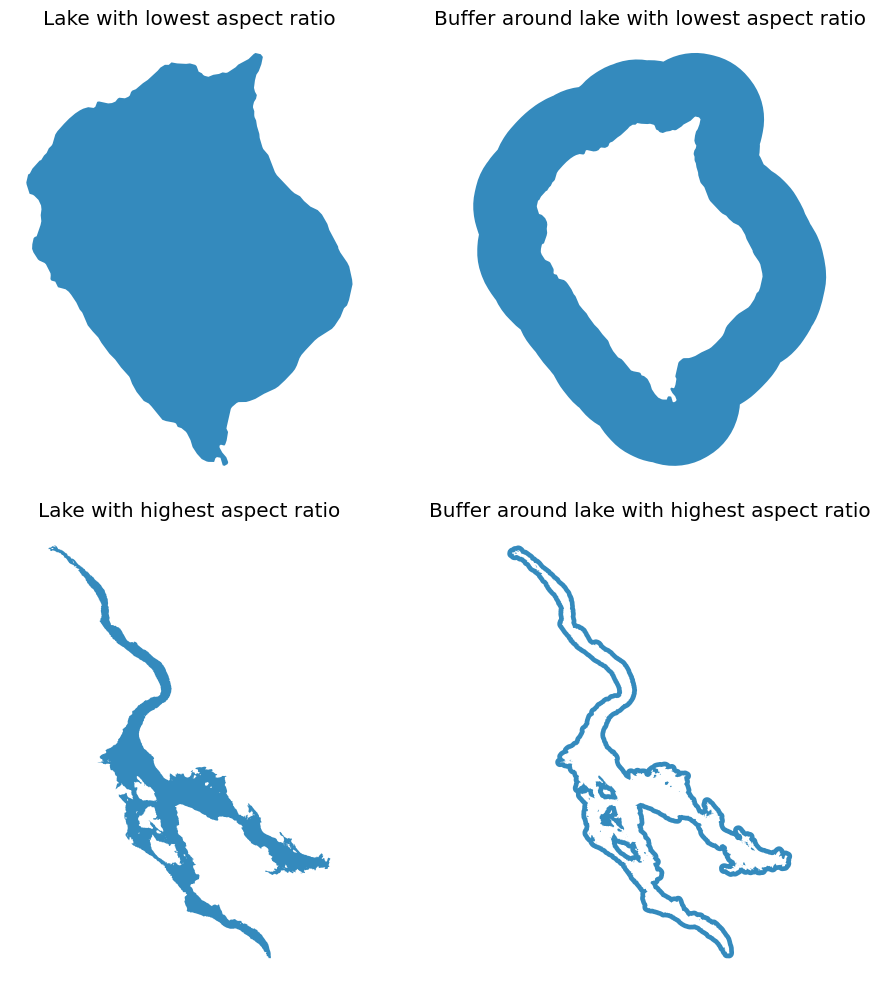

In [14]:
# Plot example buffers
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes = axes.flatten()

dep_gdf.query("vatnLnr == 28717").plot(ax=axes[0])
zone_gdf.query("vatnLnr == 28717").plot(ax=axes[1])
dep_gdf.query("vatnLnr == 3").plot(ax=axes[2])
zone_gdf.query("vatnLnr == 3").plot(ax=axes[3])

axes[0].set_title("Lake with lowest aspect ratio")
axes[1].set_title("Buffer around lake with lowest aspect ratio")
axes[2].set_title("Lake with highest aspect ratio")
axes[3].set_title("Buffer around lake with highest aspect ratio")

for ax in axes:
    ax.axis("off")

plt.tight_layout()

In [15]:
# Zonal stats for catchments
stats = [
    "min",
    "percentile_25",
    "median",
    "percentile_75",
    "max",
    "mean",
    "std",
    "count",
]

# Process each vassom in turn
df_list = []
for vassom in tqdm(vassom_list):
    dem_path = f"/home/jovyan/shared/01_datasets/spatial/dtm_merged_utm33/dtm_{dtm_res}m/by_vassom/dtm/vassom_{vassom}_{dtm_res}m_dtm.tif"
    slp_path = os.path.join(temp_fold, f"vassom_{vassom}_{dtm_res}m_slope.tif")
    vassom_zone_gdf = zone_gdf.query("vassom == @vassom").dropna(subset="geometry")

    # Calcule slopes
    gdal.DEMProcessing(
        slp_path,
        dem_path,
        "slope",
        alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
        slopeFormat="degree",  # 'degree' or 'percent'
        creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
    )

    # Zonal stats
    idx_cols = [i for i in vassom_zone_gdf.columns if i != "geometry"]
    slp_stats = [f"slp_{i}" for i in stats]
    dem_stats = [f"dem_{i}" for i in stats]
    cols = idx_cols + slp_stats + dem_stats + ["geometry"]
    slp_res_df = pd.DataFrame(
        zonal_stats(
            vectors=vassom_zone_gdf,
            raster=slp_path,
            stats=stats,
        )
    )

    dem_res_df = pd.DataFrame(
        zonal_stats(
            vectors=vassom_zone_gdf,
            raster=dem_path,
            stats=stats,
        )
    )

    # Tidy
    assert len(vassom_zone_gdf) == len(slp_res_df)
    assert len(vassom_zone_gdf) == len(dem_res_df)

    for col in slp_res_df.columns:
        vassom_zone_gdf["slp_" + col] = slp_res_df[col].values
    for col in dem_res_df.columns:
        vassom_zone_gdf["dem_" + col] = dem_res_df[col].values

    vassom_zone_gdf = vassom_zone_gdf[cols]
    vassom_zone_gdf.dropna(subset=slp_stats + dem_stats, inplace=True)
    vassom_zone_gdf.rename(
        {
            "slp_percentile_25": "slp_p25",
            "slp_percentile_75": "slp_p75",
            "dem_percentile_25": "dem_p25",
            "dem_percentile_75": "dem_p75",
        },
        axis="columns",
        inplace=True,
    )
    df_list.append(vassom_zone_gdf)
    os.remove(slp_path)

# Combine results
stats_gdf = pd.concat(df_list, axis="rows")
stats_gdf["delta_elev"] = stats_gdf["dem_mean"] - stats_gdf["dem_min"]
print(len(stats_gdf), "lakes with complete data for all variables of interest.")

# Save to CSV
stats_csv = f"../../data/lake_volume_characteristics_{dtm_res}m_dem.csv"
pd.DataFrame(stats_gdf.drop(columns="geometry")).to_csv(stats_csv, index=False)

stats_gdf.head()

  0%|          | 0/114 [00:00<?, ?it/s]

393 lakes with complete data for all variables of interest.


,vatnLnr,nve_area_km2,nve_perim_km,avg_dep_m,max_dep_m,vol_Mm3,res_time_yr,regine,area_km2,perim_km,...,dem_min,dem_p25,dem_median,dem_p75,dem_max,dem_mean,dem_std,dem_count,geometry,delta_elev
0,2,51.00,0.00,190.0,460.0,9700.000,2.897308,016.G11,51.561448,98.904355,...,185.536392,231.501785,298.698120,387.785660,803.517456,321.615926,107.385798,461823,"MULTIPOLYGON (((151697.287 6665838.194, 151697...",136.079534
1,3,78.51,206.62,20.0,68.5,1573.523,1.000000,016.J11,79.097160,214.026566,...,887.202332,926.714203,939.084290,963.946243,1249.802124,951.589676,36.593475,569540,"MULTIPOLYGON (((103495.140 6674887.870, 103501...",64.387344
2,6,58.40,0.00,87.0,171.0,5100.000,0.609125,016.B3,55.116159,142.702565,...,5.386335,30.755405,46.029766,70.731827,348.087799,56.862473,40.265094,396418,"MULTIPOLYGON (((169070.632 6595885.243, 169076...",51.476138
3,7,18.70,0.00,67.0,152.0,1260.000,0.390202,016.BB11,19.599203,53.974755,...,71.861748,94.682249,124.609795,176.051411,486.983704,145.069605,68.795806,179902,"MULTIPOLYGON (((140708.732 6592482.260, 140709...",73.207857
4,8,13.80,0.00,92.0,201.0,1280.000,0.412603,016.BB11,15.765148,44.447506,...,71.993294,96.435318,130.068390,180.989967,525.219666,147.528189,66.434956,135711,"MULTIPOLYGON (((129645.206 6602428.954, 129627...",75.534895


## 4. Statistical models for lake volume

In [16]:
# Read saved data for speed
stats_csv = f"../../data/lake_volume_characteristics_{dtm_res}m_dem.csv"
stats_df = pd.read_csv(stats_csv)

# Remove Mjøsa (see Section 2, above)
stats_df = stats_df.query("vatnLnr != 118").reset_index()

print(f"{len(stats_df)} lakes with complete data for statistical analysis.")

stats_df.describe()

392 lakes with complete data for statistical analysis.


,index,vatnLnr,nve_area_km2,nve_perim_km,avg_dep_m,max_dep_m,vol_Mm3,res_time_yr,area_km2,perim_km,...,slp_count,dem_min,dem_p25,dem_median,dem_p75,dem_max,dem_mean,dem_std,dem_count,delta_elev
count,392.000000,392.000000,392.000000,386.000000,392.000000,392.000000,392.000000,387.000000,392.000000,392.000000,...,3.920000e+02,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,3.920000e+02,392.000000
mean,196.403061,9649.114796,6.843460,8.593601,23.346097,60.182117,415.197289,1.057387,7.249240,20.381389,...,6.058962e+04,377.820729,395.296361,408.894349,430.514872,549.282294,416.567983,27.771564,6.058962e+04,38.747254
std,113.457004,14438.897693,18.122686,19.131340,28.544432,65.821606,1554.045350,2.218976,19.026668,31.492342,...,1.394490e+05,341.010691,344.687796,342.836768,341.053754,353.439722,341.892464,27.447766,1.394490e+05,38.241512
min,0.000000,2.000000,0.014400,0.000000,1.000000,2.200000,0.037400,0.000000,0.018103,0.537321,...,3.170000e+02,0.000000,6.299209,8.188160,9.981701,13.217710,8.302724,1.567751,3.170000e+02,2.032617
25%,98.750000,743.000000,0.580000,0.000000,7.750000,23.875000,5.116750,0.097000,0.626518,5.065592,...,6.657250e+03,80.859209,101.362969,129.358932,155.254381,282.733612,142.390604,9.661048,6.657250e+03,13.104694
50%,196.500000,1920.500000,1.460000,4.115000,15.000000,41.000000,20.493000,0.390202,1.536209,9.953717,...,1.517750e+04,285.373123,307.783783,317.966125,338.830624,459.086578,325.456990,18.774844,1.517750e+04,26.709813
75%,294.250000,17411.250000,4.147500,9.915000,27.000000,69.250000,96.007250,0.999500,4.783578,21.391095,...,4.177300e+04,574.613495,588.492085,596.498428,612.193176,758.724854,606.485831,35.292163,4.177300e+04,49.858207
max,392.000000,80268.000000,190.000000,225.310000,237.000000,514.000000,13130.000000,25.180552,218.048869,282.830237,...,1.534235e+06,1330.633301,1337.369995,1343.481201,1359.536163,1762.598389,1350.863734,152.638770,1.534235e+06,223.887948


### 4.1. Original method

The original TEOTIL model estimated lake volumes as the product of **mean depth** and **surface area**. Surface area was derived using GIS, while mean depth was estimated from surface area using the relationship

$$mean\_depth\_m = 1.8 \times surface\_area\_km2 + 13$$

(see Section 2.4 of the report [here](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/214825/5914-2010_200dpi.pdf?sequence=2&isAllowed=y) for details). The $R^2$ value for this regression was 0.43. Multiplying this equation for mean depth by lake area gives a quadratic relationship for lake volume

$$V = 1.8A^2 + 13A$$

where $V$ is lake volume in $Mm^3$ and $A$ is lake area in $km^2$.

                                 OLS Regression Results                                
Dep. Variable:                vol_Mm3   R-squared (uncentered):                   0.742
Model:                            OLS   Adj. R-squared (uncentered):              0.741
Method:                 Least Squares   F-statistic:                              561.4
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                   1.57e-115
Time:                        11:56:59   Log-Likelihood:                         -3184.2
No. Observations:                 392   AIC:                                      6372.
Df Residuals:                     390   BIC:                                      6380.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

/tmp/ipykernel_233/2567740592.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(res.resid.values, ax=axes[1])


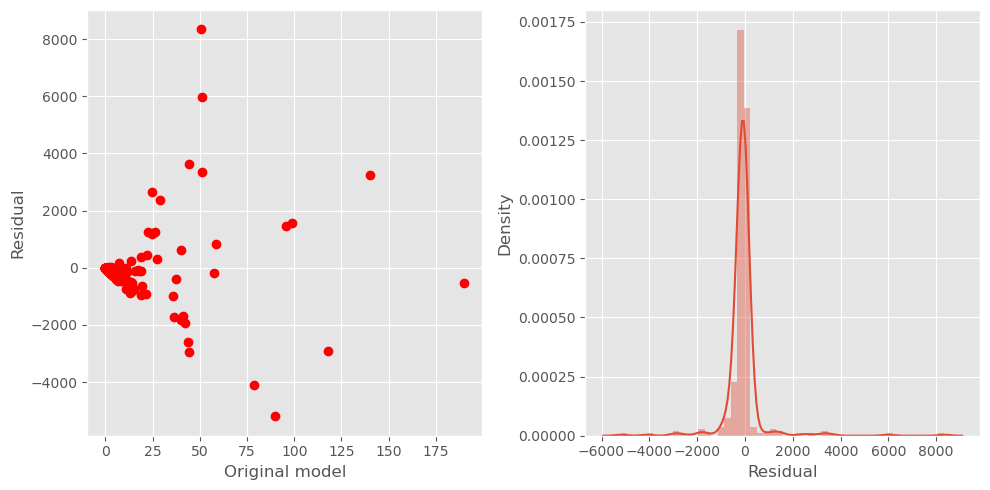

In [17]:
# Fit original TEOTIL-like polynomial
mod = smf.ols(
    formula="vol_Mm3 ~ np.power(nve_area_km2, 2) + nve_area_km2 - 1", data=stats_df
)
# mod = smf.ols(formula="np.log10(vol_Mm3) ~ np.log10(np.power(nve_area_km2, 2) + nve_area_km2) - 1", data=stats_df)
res = mod.fit()
print(res.summary())

# Plot diagnotsics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(res.model.exog[:, 1], res.resid, "ro")
axes[0].set_xlabel("Original model")
axes[0].set_ylabel("Residual")
sn.distplot(res.resid.values, ax=axes[1])
axes[1].set_xlabel("Residual")
plt.tight_layout()

The original TEOTIL-like model explains 74% of the variance in lake volumes. However, note that the power term is not statistically significant and the residuals are strongly heteroscedastic. The coefficients estimated from the latest NVE dataset are also different to those used by the original model.

RMSE for original TEOTIL volume estimates: 3464 Mm3.


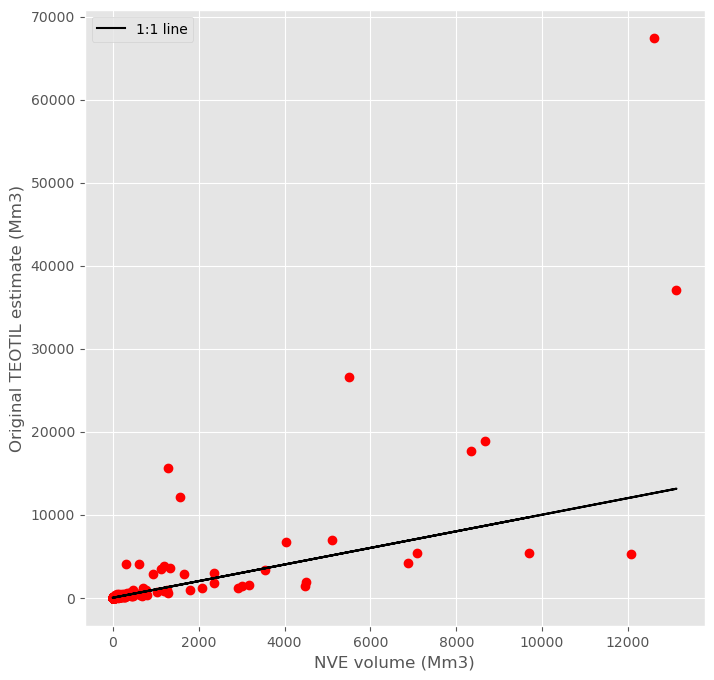

In [18]:
# Compare the original method with measured volumes
stats_df["orig_vol_Mm3"] = (
    1.8 * stats_df["nve_area_km2"] ** 2 + 13 * stats_df["nve_area_km2"]
)

# Calculate RMSE
orig_rmse = mean_squared_error(
    stats_df["vol_Mm3"], stats_df["orig_vol_Mm3"], squared=False
)
print(f"RMSE for original TEOTIL volume estimates: {orig_rmse:.0f} Mm3.")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(stats_df["vol_Mm3"], stats_df["orig_vol_Mm3"], "ro")
ax.plot(stats_df["vol_Mm3"], stats_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel("Original TEOTIL estimate (Mm3)")
ax.legend(loc="upper left")

Based on the above plot, it is clear that **the original method tends to overestimate lake volumes**. Hopefully we can do better.

### 4.2. Self-affine surfaces

There are broad theoretical reasons to consider landscapes as **self-affine surfaces**, which implies the volume of a depression will be proportional to the depressional surface area raised to some exponent (see e.g. [Delaney et al., 2022](https://www.frontiersin.org/articles/10.3389/frwa.2022.886964/full) for an overview)

$$V = \beta_0 A^{\beta_1}$$

In this formulation, the parameter $\beta_1$ is related to the [Hurst coefficient](https://en.wikipedia.org/wiki/Hurst_exponent), $H$, which controls the scaling relationship between vertical and horizontal dimensions for fractal surfaces. Based on this theory, [Cael et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL071378) proposed the relationship

$$V \propto A^{1 + \frac{H}{2}}$$

and stated that, for spatial scales relevant to lakes at the Earth's surface, $H = 0.4 \pm 0.1$ (i.e. we should expect $\beta_1$ to be about 1.2).

This model is fit in the code below using log-log linear regression. Note that the model includes $V \propto A$ as a special case (where $\beta_1 = 1$), so it is not necessary to consider a simple linear model separately. (As an aside, if I try `formula="vol_Mm3 ~ nve_area_km2"` in the code below, instead of the logged version, the residuals from the regression are non-Normal and show obvious heteroscedasticity. In other words, using a log-transformation can be justified from both physical and statistical points of view).

Note that using log-transformation incurs bias that should be corrected before making predictions. See the code and links [here](https://nbviewer.org/github/JamesSample/martini/blob/master/notebooks/process_norway_chem.ipynb#3.-Concentration-discharge-relationships) for a full explantion of the bias correction applied below.

                            OLS Regression Results                            
Dep. Variable:      np.log10(vol_Mm3)   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     3551.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):          5.55e-198
Time:                        11:57:00   Log-Likelihood:                -113.95
No. Observations:                 392   AIC:                             231.9
Df Residuals:                     390   BIC:                             239.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

/tmp/ipykernel_233/2745189003.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(res.resid.values, ax=axes[1])


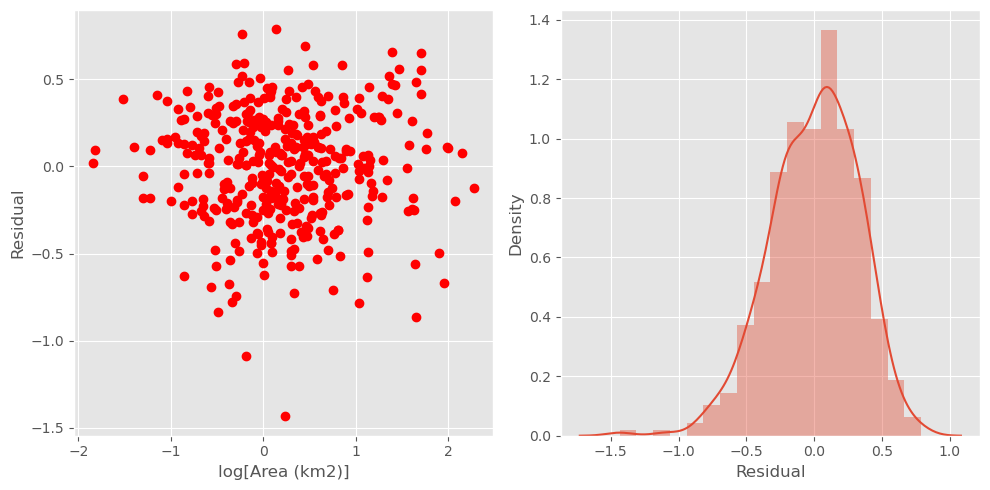

In [19]:
# log-log linear regression
mod = smf.ols(formula="np.log10(vol_Mm3) ~ np.log10(nve_area_km2)", data=stats_df)
# mod = smf.ols(formula="vol_Mm3 ~ nve_area_km2", data=stats_df)
res = mod.fit()
print(res.summary())

# Plot diagnotsics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(res.model.exog[:, 1], res.resid, "ro")
axes[0].set_xlabel("log[Area (km2)]")
axes[0].set_ylabel("Residual")
sn.distplot(res.resid.values, ax=axes[1])
axes[1].set_xlabel("Residual")
plt.tight_layout()

$R^2$ for this regression (in the log space) is ~90% and the residuals are more-or-less normal, which is good. However, because we're predicting logged values here and unlogged values above, **these results are not directly comparable to those for the original model**. To make a fair comparison, the code below transforms the predictions back to the unlogged scale, applies bias correction, and then computes the RMSE. This *can* be compared to the RMSE for the original approach given above.

Note also that the estimate for $\beta_1$ of 1.38 is reasonably close to the theoretical value of $1.2 \pm 0.05$ proposed by [Cael et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL071378).

RMSE for self-affine volume estimates: 990 Mm3.


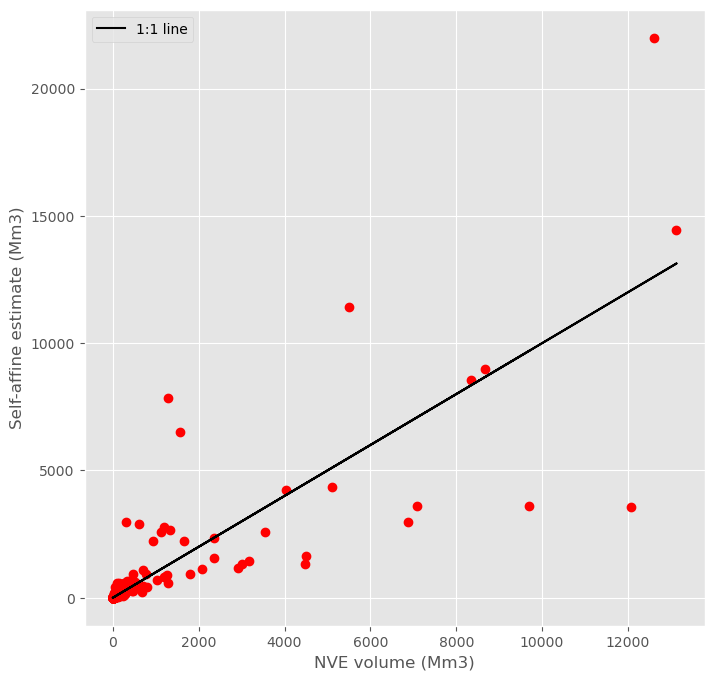

In [20]:
# Bias correction
beta_0 = 10 ** res.params[0]
beta_1 = res.params[1]
bias_fac = np.exp(2.651 * ((res.resid.values) ** 2).mean())

# Get fitted values
stats_df["sa_vol_Mm3"] = beta_0 * bias_fac * (stats_df["nve_area_km2"] ** beta_1)

# Calculate RMSE
sa_rmse = mean_squared_error(stats_df["vol_Mm3"], stats_df["sa_vol_Mm3"], squared=False)
print(f"RMSE for self-affine volume estimates: {sa_rmse:.0f} Mm3.")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(stats_df["vol_Mm3"], stats_df["sa_vol_Mm3"], "ro")
ax.plot(stats_df["vol_Mm3"], stats_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel("Self-affine estimate (Mm3)")
ax.legend(loc="upper left")

The plot above looks better than for the original TEOTIL method and the RMSE has reduced by a factor of more than 3. This new statistical model is substantially better overall than the original method. What about adding additional covariates?

### 4.3. Lake aspect ratio

                            OLS Regression Results                            
Dep. Variable:      np.log10(vol_Mm3)   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1944.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):          3.19e-203
Time:                        11:57:01   Log-Likelihood:                -97.440
No. Observations:                 392   AIC:                             200.9
Df Residuals:                     389   BIC:                             212.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

/tmp/ipykernel_233/3042491261.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(res.resid.values, ax=axes[1])


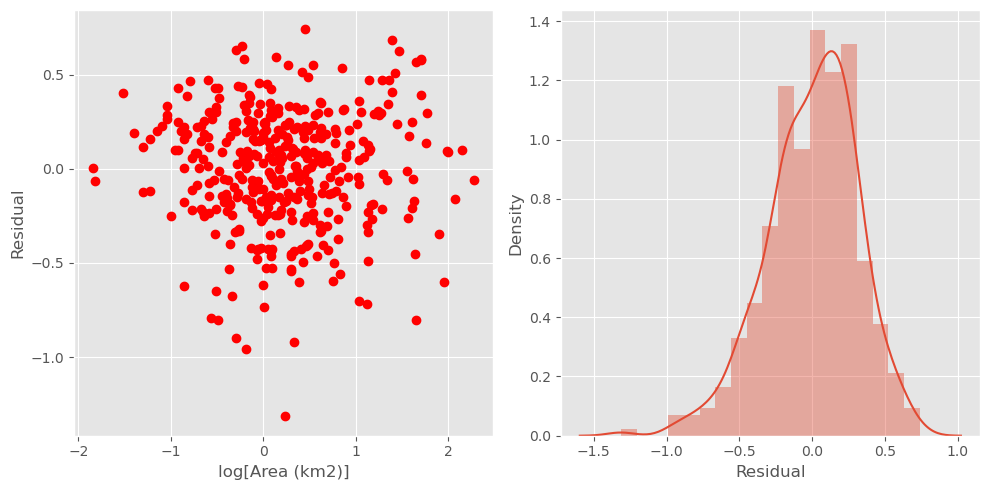

In [21]:
# log-log linear regression
mod = smf.ols(
    formula="np.log10(vol_Mm3) ~ np.log10(nve_area_km2) + np.log10(aspect_ratio)",
    data=stats_df,
)
res = mod.fit()
print(res.summary())

# Plot diagnotsics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(res.model.exog[:, 1], res.resid, "ro")
axes[0].set_xlabel("log[Area (km2)]")
axes[0].set_ylabel("Residual")
sn.distplot(res.resid.values, ax=axes[1])
axes[1].set_xlabel("Residual")
plt.tight_layout()

RMSE for self-affine volume estimates with aspect ratio included: 851 Mm3.


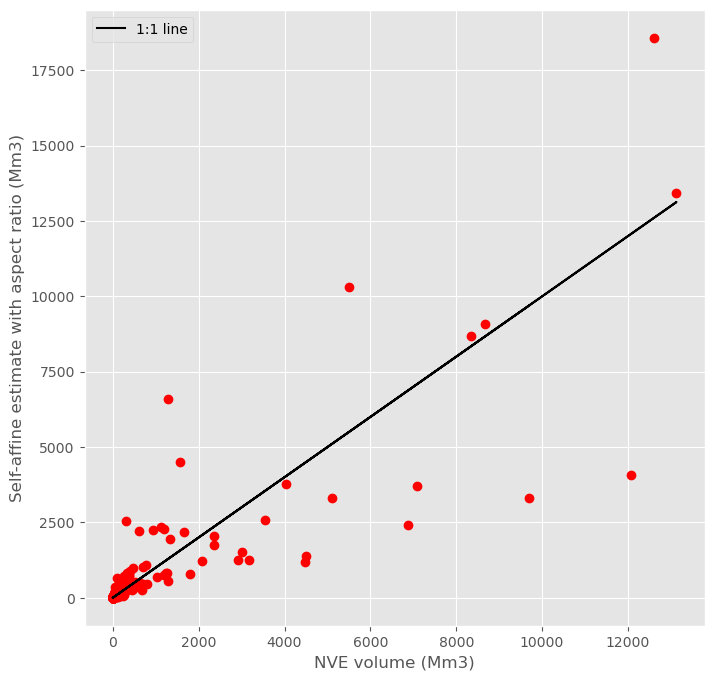

In [22]:
# Bias correction
beta_0 = 10 ** res.params[0]
beta_1 = res.params[1]
beta_2 = res.params[2]
bias_fac = np.exp(2.651 * ((res.resid.values) ** 2).mean())

# Get fitted values
stats_df["sa_asp_vol_Mm3"] = (
    beta_0
    * bias_fac
    * (stats_df["nve_area_km2"] ** beta_1)
    * (stats_df["aspect_ratio"] ** beta_2)
)

# Calculate RMSE
sa_asp_rmse = mean_squared_error(
    stats_df["vol_Mm3"], stats_df["sa_asp_vol_Mm3"], squared=False
)
print(
    f"RMSE for self-affine volume estimates with aspect ratio included: {sa_asp_rmse:.0f} Mm3."
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(stats_df["vol_Mm3"], stats_df["sa_asp_vol_Mm3"], "ro")
ax.plot(stats_df["vol_Mm3"], stats_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel("Self-affine estimate with aspect ratio (Mm3)")
ax.legend(loc="upper left")

Results for this regression *can* be directly compared to those for the self-affine approach (since both make predictions on the log scale). This model has a slight improvement in $R^2$ (91%) and all variables are highly significant. Based on both AIC and BIC, this model is  better than the self-affine alternative. Note that the coefficient for `aspect_ratio` is negative, which implies that broader lakes are deeper (see Section 3.1).

Including aspect ratio as a covariate reduces the RMSE by another 15% or so.

### 4.4. Terrain characteristics

The code below uses "best subsets" regression to identify the best model from various combinations of covariates (where "best" is defined as the model with the lowest AIC). Note that best subsets is sometimes considered [statistically dubious](https://stats.stackexchange.com/questions/20836/algorithms-for-automatic-model-selection/20856#20856) due to problems with multiple comparisons, but it is nevertheless a useful starting point for model selection. 

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                vol_Mm3   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     2831.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):          2.67e-263
Time:                        11:57:01   Log-Likelihood:                 46.293
No. Observations:                 392   AIC:                            -84.59
Df Residuals:                     388   BIC:                            -68.70
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

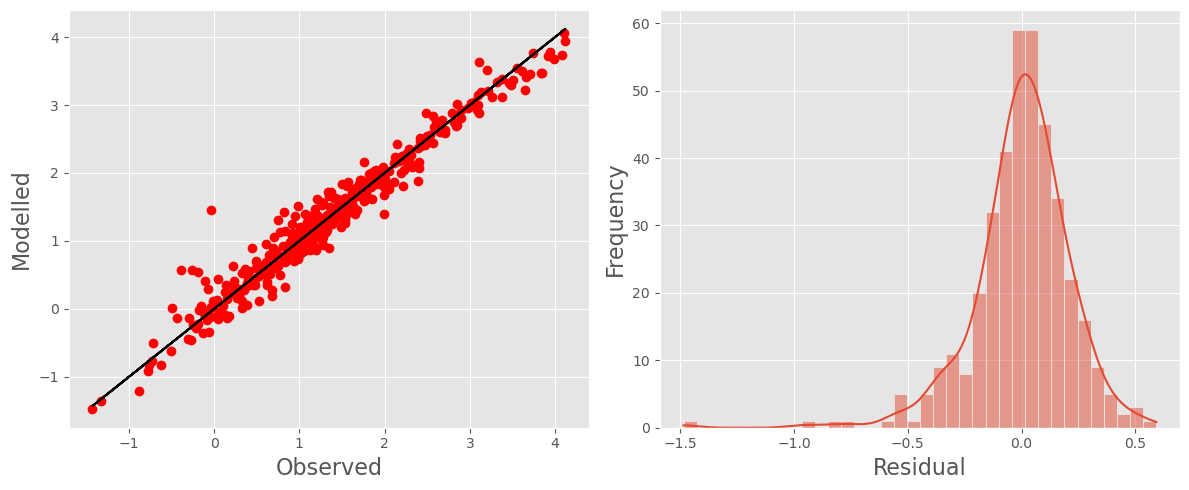

In [23]:
resp_var = "vol_Mm3"
exp_vars = [
    "nve_area_km2",
    "aspect_ratio",
    "slp_mean",
    "dem_mean",
    "delta_elev",
]
df = np.log10(stats_df[[resp_var] + exp_vars])
res, scaler = nivapy.stats.best_subsets_ols_regression(
    df, "vol_Mm3", exp_vars, standardise=False
)

RMSE for self-affine volume estimates with terrain characteristics and aspect ratio included: 589 Mm3.


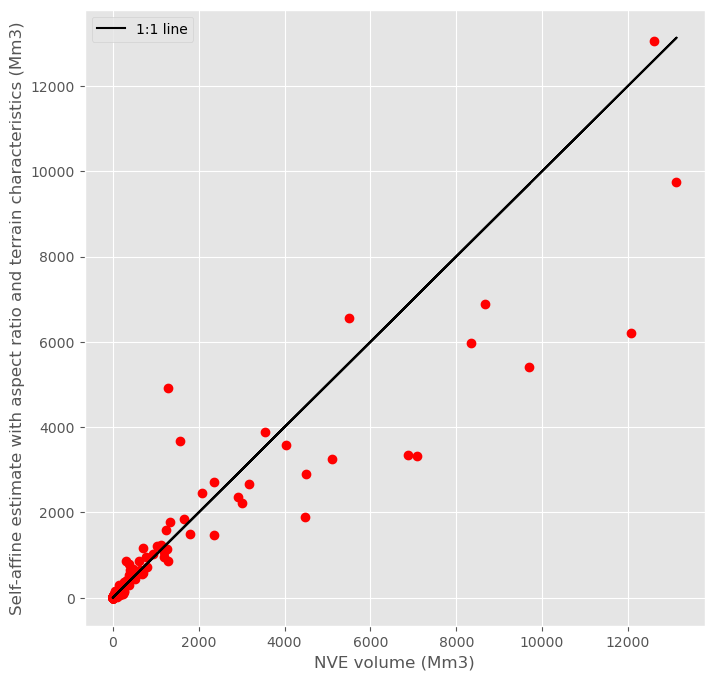

In [24]:
# Bias correction
beta_0 = res.params[0]
bias_fac = np.exp(2.651 * ((res.resid.values) ** 2).mean())

# Get fitted values
reg_vars = res.params.keys()[1:]
stats_df["terr_vol_Mm3"] = (10**beta_0) * bias_fac
for reg_var in reg_vars:
    stats_df["terr_vol_Mm3"] = stats_df["terr_vol_Mm3"] * (
        stats_df[reg_var] ** res.params[reg_var]
    )

# Calculate RMSE
terr_rmse = mean_squared_error(
    stats_df["vol_Mm3"], stats_df["terr_vol_Mm3"], squared=False
)
print(
    f"RMSE for self-affine volume estimates with terrain characteristics and aspect ratio included: {terr_rmse:.0f} Mm3."
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(stats_df["vol_Mm3"], stats_df["terr_vol_Mm3"], "ro")
ax.plot(stats_df["vol_Mm3"], stats_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel(
    "Self-affine estimate with aspect ratio and terrain characteristics (Mm3)"
)
ax.legend(loc="upper left")

### 4.5. Summary

The plots below show results for the four different statistical models (all using log-log axes), including the RMSE values. The original model gives poor performance (in terms of RMSE) and does not meet the assumptions of the regression (because the residuals are heteroscedastic). The best model is "self-affine with aspect ratio and terrain characteristics", which has an RMSE more than five times smaller than the original model used in TEOTIL.

The best model has the form

$$log(V) = \beta_0 + \beta_1 log(A) + \beta_2 log(R) + \beta_3 log(S)$$

where $V$ is lake volume in $Mm^3$; $A$ is lake area in $km^2$; $R$ is aspect ratio; and $S$ is mean topographic slope (in degrees) around the lake's margin within a buffer of `0.5 * lake_width`. Including a correction for back-transformation bias, $\alpha$, this becomes

$$V = \alpha 10^{\beta_0} A^{\beta_1} R^{\beta_2} S^{\beta_3}$$

Values for the regression coefficients are shown in the code below.

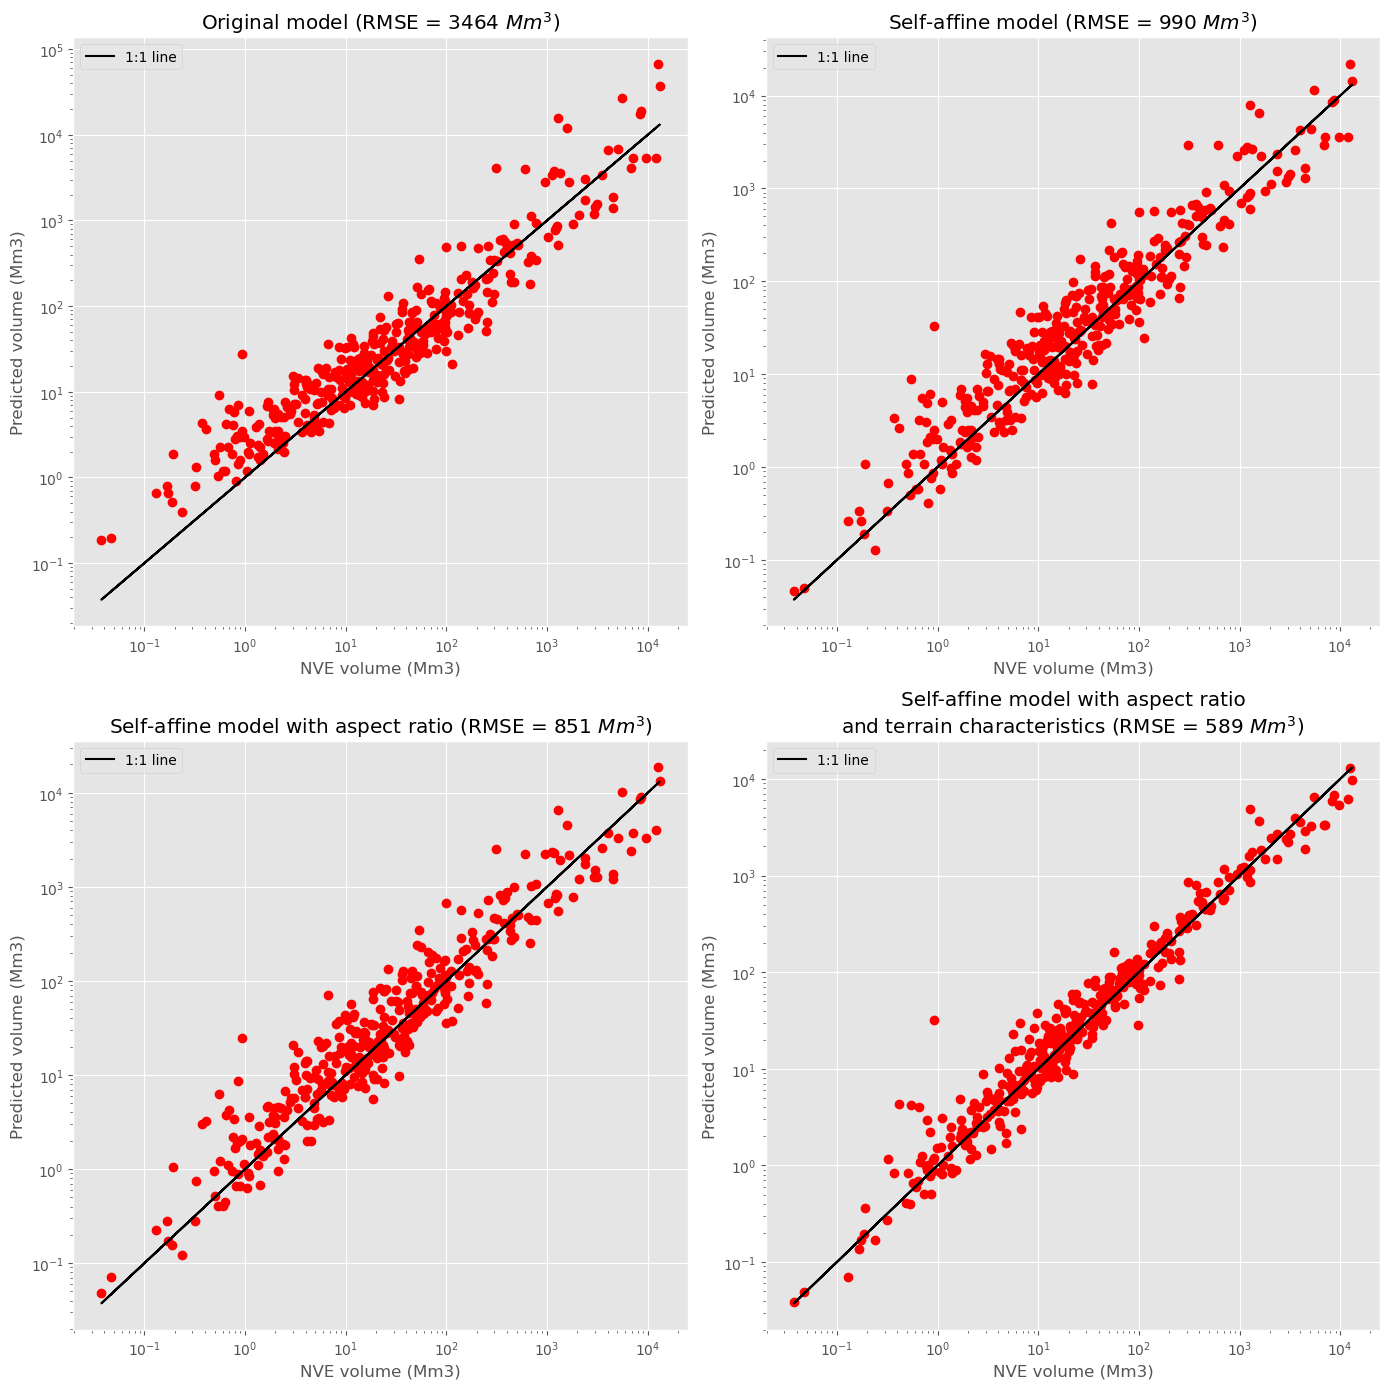

In [25]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
axes = axes.flatten()

label_dict = {
    "orig_vol_Mm3": ("Original model", orig_rmse),
    "sa_vol_Mm3": ("Self-affine model", sa_rmse),
    "sa_asp_vol_Mm3": ("Self-affine model with aspect ratio", sa_asp_rmse),
    "terr_vol_Mm3": (
        "Self-affine model with aspect ratio\nand terrain characteristics",
        terr_rmse,
    ),
}

for idx, key in enumerate(label_dict.keys()):
    axes[idx].plot(stats_df["vol_Mm3"], stats_df[key], "ro")
    axes[idx].plot(stats_df["vol_Mm3"], stats_df["vol_Mm3"], "k-", label="1:1 line")
    axes[idx].set_xlabel("NVE volume (Mm3)")
    axes[idx].set_ylabel("Predicted volume (Mm3)")
    axes[idx].set_title(
        f"{label_dict[key][0]} (RMSE = {label_dict[key][1]:.0f} $Mm^3$)"
    )
    axes[idx].legend(loc="upper left")
    axes[idx].set_xscale("log")
    axes[idx].set_yscale("log")

plt.tight_layout()

In [26]:
# Coefficients for best model
print("Bias factor:", bias_fac)
print("Parameter exponents (beta 0, 1, 2, 3):")
print(res.params)

Bias factor: 1.1303905969291164
Parameter exponents (beta 0, 1, 2, 3):
const           0.198446
nve_area_km2    1.398423
aspect_ratio   -0.174970
slp_mean        0.976878
dtype: float64


## 5. Estimate volumes for all lakes

In [27]:
# Get depth data for all lakes, including Mjøsa
stats_csv = f"../../data/lake_volume_characteristics_{dtm_res}m_dem.csv"
stats_df = pd.read_csv(stats_csv)
cols = ["vatnLnr", "vol_Mm3", "res_time_yr"]
stats_df = stats_df[cols]

# Join to lakes database
lake_gdf = lake_gdf.merge(stats_df, on="vatnLnr", how="left")

# Check all lakes have valid areas
assert pd.isna(lake_gdf["area_km2"]).sum() == 0
assert (lake_gdf["area_km2"] <= 0).sum() == 0

# Calculate aspect ratio
lake_gdf["area2_km2"] = lake_gdf["geometry"].area / 1e6
lake_gdf["perim_km"] = lake_gdf["geometry"].length / 1e3
lake_gdf["width_km"] = (
    lake_gdf["perim_km"]
    - (lake_gdf["perim_km"] ** 2 - 16 * lake_gdf["area2_km2"]) ** 0.5
) / 4
lake_gdf["length_km"] = (
    lake_gdf["perim_km"]
    + (lake_gdf["perim_km"] ** 2 - 16 * lake_gdf["area2_km2"]) ** 0.5
) / 4

lake_gdf["aspect_ratio"] = lake_gdf["length_km"] / lake_gdf["width_km"]

# Handle complex results
lake_gdf["aspect_ratio"].fillna(1, inplace=True)
lake_gdf["width_km"].fillna(lake_gdf["area2_km2"]**0.5, inplace=True)

assert np.iscomplex(lake_gdf["width_km"]).sum() == 0
assert np.iscomplex(lake_gdf["length_km"]).sum() == 0

del lake_gdf["length_km"], lake_gdf["area2_km2"], lake_gdf["perim_km"]
lake_gdf.dropna(subset="aspect_ratio", inplace=True)

In [28]:
# Buffer based on width
buffer = 0.5 * 1000 * lake_gdf["width_km"]
temp_fold = r"/home/jovyan/shared/01_datasets/spatial/temp"

reg_list = lake_gdf["regine"].unique().tolist()
vassom_list = lake_gdf["vassom"].unique().tolist()
print(
    f"The lakes dataset includes lakes from {len(reg_list)} regines in {len(vassom_list)} vassdragsområder."
)

# Buffer lakes and clip to create zone dataset
zone_gdf = lake_gdf.copy()
zone_gdf["geometry"] = zone_gdf.buffer(buffer)
zone_gdf = zone_gdf.overlay(lake_gdf, how="difference")
zone_gdf.head()

The lakes dataset includes lakes from 12679 regines in 261 vassdragsområder.


,vatnLnr,name,regine,vassom,elev_m,area_km2,catch_area_km2,vol_est_avail,geometry,vol_Mm3,res_time_yr,width_km,aspect_ratio
0,505,Aahkanjaevrie,155.D1B,155,718.0,3.4267,16.06,0,"POLYGON ((445535.820 7294224.308, 445532.345 7...",NaN,NaN,0.640903,8.342478
1,36452,Svartvatnet,116.B,116,419.0,0.0494,0.37,0,"POLYGON ((191782.358 7031007.376, 191779.274 7...",NaN,NaN,0.081344,7.467724
2,81309,Gåntjern,002.ACB,002,207.0,0.0397,0.36,0,"POLYGON ((301067.981 6596691.859, 301068.211 6...",NaN,NaN,0.071567,7.751933
3,36412,Litlvatnet,119.110,119,258.0,0.0332,0.70,0,"POLYGON ((202050.545 7035977.365, 202054.448 7...",NaN,NaN,0.082139,4.920722
4,36305,Kvernavatnet,117.310,117,41.0,0.0501,1.05,0,"POLYGON ((172765.150 7050794.912, 172761.702 7...",NaN,NaN,0.074070,9.122985


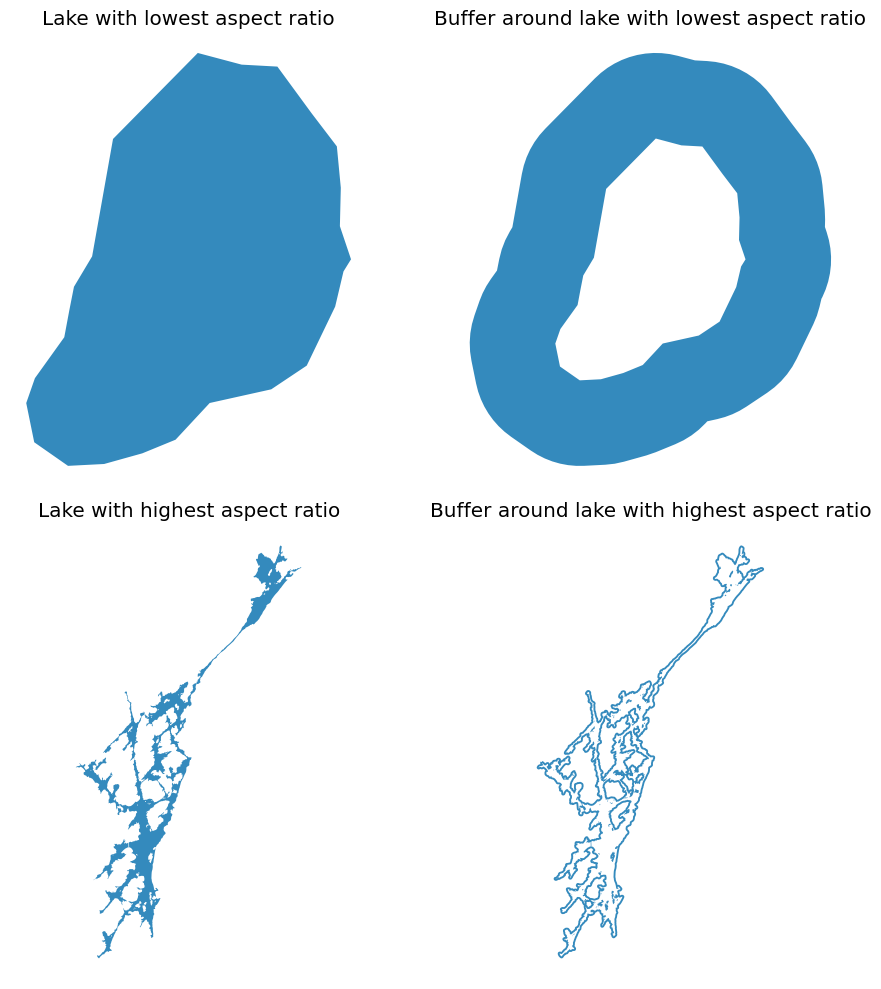

In [29]:
# Plot example buffer
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes = axes.flatten()

lake_gdf.sort_values("aspect_ratio").iloc[[0]].plot(ax=axes[0])
zone_gdf.sort_values("aspect_ratio").iloc[[0]].plot(ax=axes[1])
lake_gdf.sort_values("aspect_ratio").iloc[[-1]].plot(ax=axes[2])
zone_gdf.sort_values("aspect_ratio").iloc[[-1]].plot(ax=axes[3])

axes[0].set_title("Lake with lowest aspect ratio")
axes[1].set_title("Buffer around lake with lowest aspect ratio")
axes[2].set_title("Lake with highest aspect ratio")
axes[3].set_title("Buffer around lake with highest aspect ratio")

for ax in axes:
    ax.axis("off")

plt.tight_layout()

In [30]:
# Zonal stats for catchments
stats = [
    "mean",
]

# Process each vassom in turn
df_list = []
for vassom in tqdm(vassom_list):
    dem_path = f"/home/jovyan/shared/01_datasets/spatial/dtm_merged_utm33/dtm_{dtm_res}m/by_vassom/dtm/vassom_{vassom}_{dtm_res}m_dtm.tif"
    slp_path = os.path.join(temp_fold, f"vassom_{vassom}_{dtm_res}m_slope.tif")
    vassom_zone_gdf = zone_gdf.query("vassom == @vassom").dropna(subset="geometry")

    # Calcule slopes
    gdal.DEMProcessing(
        slp_path,
        dem_path,
        "slope",
        alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
        slopeFormat="degree",  # 'degree' or 'percent'
        creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
    )

    # Zonal stats
    idx_cols = [i for i in vassom_zone_gdf.columns if i != "geometry"]
    slp_stats = [f"slp_{i}" for i in stats]
    cols = idx_cols + slp_stats + ["geometry"]
    slp_res_df = pd.DataFrame(
        zonal_stats(
            vectors=vassom_zone_gdf,
            raster=slp_path,
            stats=stats,
        )
    )

    # Tidy
    assert len(vassom_zone_gdf) == len(slp_res_df)

    for col in slp_res_df.columns:
        vassom_zone_gdf["slp_" + col] = slp_res_df[col].values

    vassom_zone_gdf = vassom_zone_gdf[cols]
    vassom_zone_gdf.dropna(subset=slp_stats, inplace=True)
    df_list.append(vassom_zone_gdf)
    os.remove(slp_path)

# Combine results
stats_gdf = pd.concat(df_list, axis="rows")

print("Slope characteristics derived for", len(stats_gdf), "lakes.")

  0%|          | 0/261 [00:00<?, ?it/s]

Slope characteristics derived for 54721 lakes.


In [31]:
# Estimate volumes
stats_gdf["nve_area_km2"] = stats_gdf["area_km2"]
stats_gdf["vol_est_Mm3"] = (10**beta_0) * bias_fac
for reg_var in reg_vars:
    stats_gdf["vol_est_Mm3"] = stats_gdf["vol_est_Mm3"] * (
        stats_gdf[reg_var] ** res.params[reg_var]
    )
del stats_gdf["nve_area_km2"]

RMSE for self-affine volume estimates with terrain characteristics and aspect ratio included: 618 Mm3.


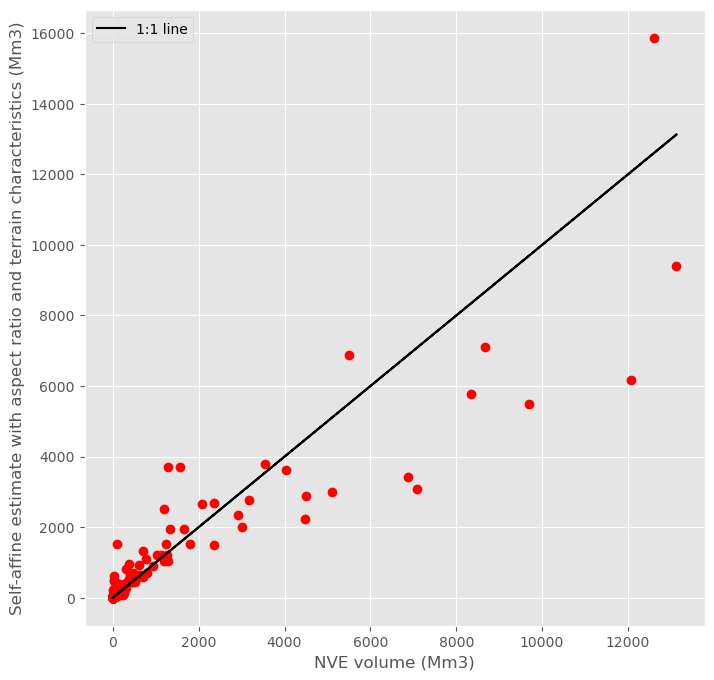

In [32]:
# Check results look reasonable
check_df = stats_gdf.dropna(subset="vol_Mm3").copy()
check_df = check_df.query("vatnLnr != 118")

rmse = mean_squared_error(check_df["vol_Mm3"], check_df["vol_est_Mm3"], squared=False)
print(
    f"RMSE for self-affine volume estimates with terrain characteristics and aspect ratio included: {rmse:.0f} Mm3."
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(check_df["vol_Mm3"], check_df["vol_est_Mm3"], "ro")
ax.plot(check_df["vol_Mm3"], check_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel(
    "Self-affine estimate with aspect ratio and terrain characteristics (Mm3)"
)
ax.legend(loc="upper left")

**Note:** The RMSE above is not *exactly* the same as for the model in Section 4.4 (`RMSE = 590 Mm3`) because we are now using lake areas from the main lakes database, which are not identical to those in the depth dataset (see Section 2 for further details).

In [33]:
# Save to CSV
stats_csv = f"../../data/lake_volume_estimates_{dtm_res}m_dem.csv"
pd.DataFrame(stats_gdf.drop(columns="geometry")).to_csv(stats_csv, index=False)

stats_gdf.head()

,vatnLnr,name,regine,vassom,elev_m,area_km2,catch_area_km2,vol_est_avail,vol_Mm3,res_time_yr,width_km,aspect_ratio,slp_mean,geometry,vol_est_Mm3
0,505,Aahkanjaevrie,155.D1B,155,718.0,3.4267,16.06,0,NaN,NaN,0.640903,8.342478,20.292557,"POLYGON ((445535.820 7294224.308, 445532.345 7...",130.487026
95,42531,Sijliesjaevrie,155.D32,155,585.0,0.4929,6.87,0,NaN,NaN,0.192160,13.349850,7.698064,"MULTIPOLYGON (((441355.487 7279092.026, 441354...",3.097303
801,45240,Gullriktjørnene,155.4C,155,749.0,0.0565,1.56,0,NaN,NaN,0.063771,13.904983,15.258591,"POLYGON ((455863.611 7330153.573, 455864.341 7...",0.290161
908,91116,Ryptjønna,155.AA0,155,774.0,0.0288,0.30,0,NaN,NaN,0.100792,2.830671,8.449771,"POLYGON ((449986.217 7326820.958, 449987.447 7...",0.083869
940,42243,Grubblivatnet,155.D8,155,495.0,0.0813,1.18,0,NaN,NaN,0.201466,2.002869,11.670656,"POLYGON ((466346.796 7299091.321, 466350.791 7...",0.521389
